In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [101]:
# EULER INTEGRATION FUNCTIONS:
def fs_evo_eq(fs,pis,qs,l,lci):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] - lci*fs[site_i]*(sum(fs[1:site_i])+sum(fs[site_i+1:]))
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

def ci1(x, thresh):
    ci = 1.0 if x >= thresh else 0.0
    return ci

def fs_evo_eq_ci1(fs,pis,qs,l,cithresh):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        others_com = sum(fs[1:site_i])+sum(fs[site_i+1:])
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] - fs[site_i]*ci1(others_com,cithresh)*others_com
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

def fs_evo_eq_ci1_indv(fs,pis,qs,l,cithresh):
    dfsdt = [0.0,]
    Nsites = len(fs)-1
    for i in range(len(fs)-1):
        site_i = i+1
        others = [j for j in range(1,Nsites+1) if j != site_i]
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i]
        for j in others:
            dfdt -= (1/(Nsites-1))*fs[site_i]*ci1(fs[j],cithresh)
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

In [38]:
def sols_from_intEvo(pis, qs, l, lci, fs0, evofunc, max_time=2000):
    fs = fs0
    dt = 1
    for _ in range(max_time):
        dfsdt = evofunc(fs,pis,qs,l,lci)
        fs = [f+dfdt*dt for f,dfdt in zip(fs,dfsdt)]
    return fs

def get_time_evo_int(pis, qs, l, lci, fs0, max_time=2000):
    fs = fs0
    dt = 1
    fs_evo = [[fs0[0], ], [fs0[1], ], [fs0[2], ]]
    for _ in range(max_time):
        dfsdt = fs_evo_eq(fs,pis,qs,l,lci)
        fs = [f+dfdt*dt for f,dfdt in zip(fs,dfsdt)]
        for k in range(len(fs0)):
            fs_evo[k].append(fs[k])
    return fs_evo

In [108]:
pis, qs, l = [0.1, 0.1], [10.0, 10.0], 0.9
lci = l
fs0 = [0.0, 0.51, 0.49]
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
print(fs)

lci = 0.5 # ci as step function, lci indicates threshold
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1)
print(fs)

# fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1_indv)
# print(fs)

[0.1111111111111111, 0.8874978230528197, 0.0013910658360692023]
[0.109739580617484, 0.8890277534427867, 0.0012326659397287876]


In [109]:
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1, max_time=10)
print(fs)

[0.1101380927931941, 0.8885941358178073, 0.0012677713889984274]


### 3 sites test

In [100]:
pis, qs, l = [0.1, 0.1, 0.1], [10.0, 10.0, 10.0], 0.6
lci = l
fs0 = [0.0, 0.34, 0.33, 0.33]
# fs0 = [0.0, 0.5, 0.25, 0.25]
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq)
print(fs)

lci = 0.5 # ci as step function, lci indicates threshold
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1)
print(fs)

# fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1_indv)
# print(fs)

[0.18209028657690735, 0.7870624736026123, 0.015423619910240632, 0.015423619910240632]
[0.15429050464201255, 0.8311165951375211, 0.007296450110233367, 0.007296450110233367]


In [91]:
fs = sols_from_intEvo(pis, qs, l, lci, fs0, fs_evo_eq_ci1, max_time=2)
print(fs)

[1.024, -0.03400000000000006, 0.004999999999999977, 0.004999999999999977]


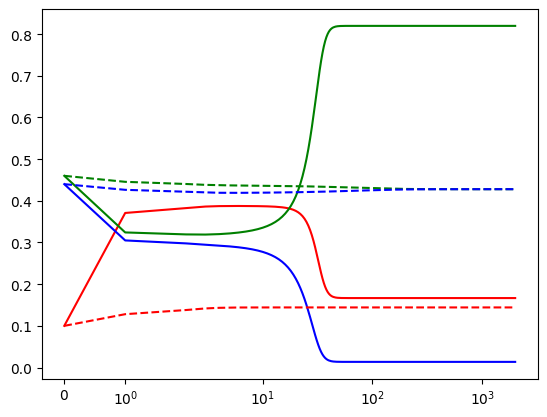

In [33]:
fs0 = [0.1, 0.46, 0.44]

fs_evo = get_time_evo_int(pis, qs, l, lci, fs0)
fig, ax = plt.subplots()
ax.set(xscale='symlog')
iters = list(range(len(fs_evo[0])))
ax.plot(iters, fs_evo[0], color='r')
ax.plot(iters, fs_evo[1], color='g')
ax.plot(iters, fs_evo[2], color='b')

fs_evo = get_time_evo_int(pis, qs, l, 0.0, fs0)
ax.set(xscale='symlog')
iters = list(range(len(fs_evo[0])))
ax.plot(iters, fs_evo[0], color='r', ls='--')
ax.plot(iters, fs_evo[1], color='g', ls='--')
ax.plot(iters, fs_evo[2], color='b', ls='--')
